In [205]:
VERSION = '56'

# Prelude

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import simpy

In [207]:
import os 

In [208]:
def isNearZero(x, ε = 0.00001):
    return abs(x)<ε

# Visualisation

[TOC](#Table-of-Contents)

This section provides two methods: 

`displayMap` takes a Network as parameter and creates a visual representation of the road network. This is useful to test
the layout of a road network.

`animate` takes two parameters: a recorder and a filename. After running a simulation it extracts the data from the recorder and creates an animated gif file of the 
simulation. 

The code given below can be safely ignored.

In [209]:
def createBackground(nw):

        idata = np.zeros( (nw.height,nw.width,3), dtype=np.uint8 )

        darkgreen =  (0, 128, 0)     # "darkgreen" 
        darkgray =   (80, 80, 80)    # "darkgray"
        dirtywhite = (250, 250, 250) # "white" 
        dirtyblack = (20, 20, 20)    # "black"
        
        def fill(x0, x1, y0, y1, c):
            nonlocal idata
            for x in range(x0, x1+1):
                for y in range(y0, y1+1):
                    for i in range(3):
                        # idata[y,x,i] = c[i]
                        idata[nw.height-1-y,x,i] = c[i]
            # plt.fill_between([x0, x1], [y0, y0], [y1, y1], color=c)
        
        def green(x0, x1, y0, y1):
            fill(x0, x1, y0, y1, darkgreen)
        def gray(x0, x1, y0, y1):
            fill(x0, x1, y0, y1, darkgray)
        def white(x0, x1, y0, y1):
            fill(x0, x1, y0, y1, dirtywhite)
        def black(x0, x1, y0, y1):
            fill(x0, x1, y0, y1, dirtyblack)
        def tl_red(x0, y0):
            fill(x0, x0+1, y0, y0+1, (255,0,0))
        def tl_green(x0, y0):
            fill(x0, x0+1, y0, y0+1, (0,255,0))
        def tl_yellow(x0, y0):
            fill(x0, x0+1, y0, y0+1, (255,255,0))
        
        def dline(x0, x1, y0, y1):
            nonlocal idata
            if y0==y1:  # horizontal line
                for x in range(x0, x1+1):
                    if (x//4)%2==0:
                        for i in range(3):
                            idata[nw.height-1-y0, x, i] = dirtywhite[i]  
            elif x0==x1: # vertical line:
                for y in range(y0, y1+1):
                    if (y//4)%2==0:
                        for i in range(3):
                            idata[nw.height-1-y, x0, i] = dirtywhite[i]  
        
        def fline(x0, x1, y0, y1):
            nonlocal idata
            if y0==y1:  # horizontal line
                for x in range(x0, x1+1):
                    for i in range(3):
                        idata[nw.height-1-y0, x, i] = dirtywhite[i]
            elif x0==x1: # vertical line:
                for y in range(y0, y1+1):
                    for i in range(3):
                        idata[nw.height-1-y, x0, i] = dirtywhite[i]
            else:
                raise ValueError("Illegal fline")
                
        green(0, nw.width-1, 0, nw.height-1)
        LW = nw.LW
        SL = nw.SL
        
        for X in nw.intersections.values():
            if not X.crossRoadIsThroughRoad(EAST) and \
                    not X.crossRoadIsThroughRoad(NORTH):
                gray(X.x-LW, X.x+LW, X.y-LW, X.y+LW)  
                        
        for r in nw.getRoads(NORTH_SOUTH):
                   for s in r.segments:
                            begin = nw.height-1 if s.begin is None else s.begin.y-LW
                            end = 0 if s.end is None else s.end.y+LW
                            gray(r.x-LW, r.x+LW, end, begin)
                            center = (begin+end)//2
                            if s.giveWaySOUTH:
                                dline(r.x, r.x, end+SL, center)
                                fline(r.x, r.x, end+1, end+SL)
                                white(r.x, r.x+LW, end+1, end+2)
                            else:
                                dline(r.x, r.x, end, center)
                            if s.giveWayNORTH:
                                dline(r.x, r.x, center, begin-SL)
                                fline(r.x, r.x, begin-SL, begin)
                                white(r.x-LW, r.x, begin-1, begin)                               
                            else:
                                dline(r.x, r.x, center, begin)

        for r in nw.getRoads(EAST_WEST):
                    for s in r.segments:
                            begin = nw.width-1 if s.begin is None else s.begin.x-LW
                            end = 0 if s.end is None else s.end.x+LW
                            gray(end, begin, r.y-LW, r.y+LW)
                            center = (begin+end)//2
                            if s.giveWayWEST:
                                dline(end+SL, center, r.y, r.y)
                                fline(end+1, end+SL, r.y, r.y)
                                white(end+1, end+2, r.y-LW, r.y)
                            else:
                                dline(end, center, r.y, r.y)
                            if s.giveWayEAST:
                                dline(center, begin-SL, r.y, r.y)
                                fline(begin-SL, begin, r.y, r.y)
                                white(begin-1, begin, r.y, r.y+LW)                               
                            else:
                                dline(center, begin, r.y, r.y)    
        return idata

In [210]:
from PIL import Image

def displayMap(nw):
        # was formerly a method in class network
        idata = createBackground(nw)
            
        res = 100 # [dpi]
        fig = plt.figure(dpi=res)
        fig.set_figwidth(1.32*nw.width/res-0.226)
        fig.set_figheight(1.32*nw.height/res-0.226)
    
        ax = plt.gca()
        ax.axis('off')
    
        plt.xlim(0, nw.width-1)
        plt.ylim(0, nw.height-1)

        def flatten(l):
            return [ (r,g,b) for row in l for [r,g,b] in row ]
        
        img = Image.new('RGB', (nw.width, nw.height))
        img.putdata(flatten(idata.tolist()))
        img2=img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        plt.imshow(img2)

In [211]:
from matplotlib.animation import FuncAnimation
import copy
from PIL import Image
       
       
def animate(rec, filename, start_time=None, end_time=None):
    
    filename += "_"+VERSION+".gif"

    background = createBackground(rec.network)
    
    data = rec.getData()
    timerevents = data[data['event']=='timer']
    
    # vehicle visualisation size parameter
    VL = rec.network.VL   # lengt
    VW = rec.network.VW   # width
    
    height = rec.network.height
    width = rec.network.width
    
    brightWhite = (255, 255, 255)
    darkBlue = (0, 0, 180)
    darkRed = (180, 0, 0)
    darkgreen = (0, 200, 0)
    orange = (200, 120, 0)
    black = (0, 0, 0)
    darkGray = (50, 50, 50)
    
    def flatten(l):
        return [ (r,g,b) for row in l for [r,g,b] in row ]

    def fill(idata, x0, x1, y0, y1, c):
        
        for x in range(max(x0,0), min(x1+1,width)):
            for y in range(max(y0,0), min(y1+1,height)):
                for i in range(3):
                    idata[height-1-y,x,i] = c[i]
    
    def vehicle(idata, x, y, direction, color):
        
        VW = rec.network.VW
        VL = rec.network.VL
        x = int(round(x,0))
        y = int(round(y,0))
        
        if color=='red':
            color = darkRed
        elif color=='blue':
            color = darkBlue
        elif color=='green':
            color = darkgreen
        elif color=='black':
            color = black
        elif color=='orange':
            color = orange
        else:
            raise ValueError('undefined color:', color)
        
        if direction=='SOUTH':
            fill(idata, x-VW//2, x+VW//2, y, y+VL-1, color)
            fill(idata, x-VW//2, x-VW//2, y, y, brightWhite)
            fill(idata, x+VW//2, x+VW//2, y, y, brightWhite)

        elif direction=='NORTH':
            fill(idata, x-VW//2, x+VW//2, y-VL+1, y, color)
            fill(idata, x+VW//2, x+VW//2, y, y, brightWhite)
            fill(idata, x-VW//2, x-VW//2, y, y, brightWhite)
            
        elif direction=='EAST':
            fill(idata, x-VL+1, x, y-VW//2, y+VW//2, color)
            fill(idata, x, x, y+VW//2, y+VW//2, brightWhite)
            fill(idata, x, x, y-VW//2, y-VW//2, brightWhite)
            
        elif direction=='WEST':
            fill(idata, x, x+VL-1, y-VW//2, y+VW//2, color)
            fill(idata, x, x, y+VW//2, y+VW//2, brightWhite)
            fill(idata, x, x, y-VW//2, y-VW//2, brightWhite)
            
        else:
            raise ValueError('illegal direction')
        
    def snapshot(t):

        # get a fresh copy of the background image
        idata = copy.deepcopy(background)
        print('.', end='')
 
        current = timerevents[timerevents['t']==t]
        vehicles = list(current['id'])
        for id in vehicles:
            v = current[current['id']==id]
            x = v['x'].values[0]
            y = v['y'].values[0]
            d = v['dir'].values[0]
            c = v['col'].values[0]
            vehicle(idata, x, y, d, color=c)
        

        img = Image.new('RGB', (width, height))
        # note flatten is the slowest operation 
        # it takes about 90% of the execution time of
        # snapshot, around 60ms. However animation
        # framework takes about 500ms per snapshot
        img.putdata(flatten(idata.tolist()))
        img2=img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        plt.imshow(img2)
 
    res = 120 # [dpi]
    fig = plt.figure(dpi=res, frameon=False)
    fig.set_figwidth(width//res)
    fig.set_figheight(height//res)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.xlim(0, width-1)
    plt.ylim(0, height-1)
    
    if start_time is None:
        start_time = rec.startTime # timerevents['t'].min()
        
    if end_time is None:
        end_time = rec.stopTime # timerevents['t'].max()
        
    Δt = rec.timeStep
    
    times = np.arange(start_time, end_time+Δt/2, Δt)
    
    # interval: update frequency in milliseconds
    anim = FuncAnimation(fig, snapshot, repeat=True, repeat_delay=2000, 
                         frames=times,       
                         interval=100) 
                
    # extra args control how often the animation should be looped extra_args=['-loop','-1']
    anim.save(filename, dpi=300, writer='imagemagick')
    
    print('done')

# Road Network

[TOC](#Table-of-Contents)

A National Road goes straight in North-South direction through a town. It divides the town in two parts, the eastern Old Town and the western New Town. 

- `St` for Street going in North-South direction
- `Rd` for Roads going in East-West direction
- `Bd` for Border denoting the limits of the drawing area
- `N`, `S`, `E`, `W`, `M` stands for North, South, East, West and Main
- Streets and Roads have two lanes marked by their direction:
`WSt_Nbd` describes the North bound lane of West Street
- Intersections are described by adding `x` and the name of the crossing street or road and an `i` or `o` indicating the point of entering *into* or coming *out of* the crossing, like `WSt_Nbd_xNRd_i`

In [212]:
# Global constants indicating main directions

NORTH = "NORTH"
SOUTH = "SOUTH"
EAST = "EAST"
WEST = "WEST"

NORTH_SOUTH = 'NORTH-SOUTH'
EAST_WEST = 'EAST-WEST'

def left(direction):
    if direction is NORTH:
        return WEST
    elif direction is SOUTH:
        return EAST
    elif direction is EAST:
        return NORTH
    elif direction is WEST:
        return SOUTH
    else:
        raise ValueError("illegal direction: "+direction)
        
def right(direction):
    return opposite(left(direction))
        
def cross(direction):
    if direction is NORTH_SOUTH:
        return EAST_WEST
    elif direction is EAST_WEST:
        return NORTH_SOUTH
    else:
        raise ValueError("illegal direction: "+direction)
        
def opposite(direction):
    if direction is NORTH:
        return SOUTH
    elif direction is SOUTH:
        return NORTH
    elif direction is EAST:
        return WEST
    elif direction is WEST:
        return EAST
    else:
        raise ValueError("illegal direction: "+direction)
        
def mainDirection(direction):
    if direction is NORTH or direction is SOUTH:
        return NORTH_SOUTH
    elif direction is EAST or direction is WEST:
        return EAST_WEST
    else:
        raise ValueError("illegal direction: "+direction)

In [213]:
# Global constants indicating relative directions
LEFT = "LEFT"
RIGHT = "RIGHT"

def look(leftOrRight, direction):
    if leftOrRight is LEFT:
        return left(direction)
    elif leftOrRight is RIGHT:
        return right(direction)
    else:
        raise ValueError("unexpected: "+leftOrRight)

## Roads

In [214]:
class Road:
    def __init__(self, network, name, shortName, direction, coord):
        
        global NORTH_SOUTH, EAST_WEST
        
        self.network = network
        self.name = name
        self.shortName = shortName
        self.segments = []
        if direction == NORTH_SOUTH:
            self.direction = NORTH_SOUTH
            self.x = int(round(coord*network.width, 0))
            self.y = None
            self.length = network.height
        elif direction == EAST_WEST:
            self.direction = EAST_WEST
            self.x = None
            self.y = int(round(coord*network.height, 0))
            self.length = network.width
        else:
            raise ValueError('illegal Road direction: '+direction)
        network.roads.append(self)
        if network.rec is not None:
            network.rec.registerRoad(self)
       
    def __str__(self):
        return self.name
    
    def getName(self):
        return self.name
    
    def getShortName(self):
        return self.shortName
    
    def getX(self):
        if self.x is not None:
            return self.x
        else:
            raise ValueError('illegal coordinate for: ', self.direction)
            
    def getY(self):
        if self.y is not None:
            return self.y
        else:
            raise ValueError('illegal coordinate for: ', self.direction)
            
    def addSegment(self, segment):
        self.segments.append(segment)
        
    def getRoadSegment(self, x, y):
        for s in self.segments:
            if s.contains(x, y):
                return s
        return None
    
    def getLength(self):
        return self.length
    
    def getIntersection(self, r):
        return self.network.getIntersection(self, r)
    
    def getCrossRoads(self):
        return self.network.getRoads(cross(self.direction))
        
    def getIntersections(self):
        return [ self.getIntersection(r) 
                    for r in self.getCrossRoads() ]
    
    def getIntersectionPoints(self, direction):
        intersections = self.getIntersections()
        if self.direction is NORTH_SOUTH:
            if direction is NORTH:
                return [ i.y for i in intersections]
            else:
                return [ self.length-i.y for i in intersections]
        else:  # EAST_WEST
            if direction is EAST:
                return [ i.x for i in intersections]
            else:
                return [ self.length-i.x for i in intersections]
        
    def freeDist(self, direction, r):
        intersection = self.getIntersection(r)
        queueLength = intersection.getQueueLength(direction)
        s = intersection.stop(direction, queueLength)
        if self.direction is NORTH_SOUTH:
            y = s[1] if direction==NORTH else self.length-s[1]
            return y
        else:
            x = s[0] if direction==EAST else self.length-s[0]
            return x
        
    def freeDistance(self, direction):
        crossRoads = self.getCrossRoads()
        distances = [ self.freeDist(direction, r) 
                        for r in crossRoads ]
        return min(distances)
    
    def getVehicles(self, direction):
        acc = []
        for v in self.network.rec.vehicles:
            if v.road==self and v.direction==direction:
                acc.append(v)
        return acc

## Intersections

In [215]:
class Intersection:
    def __init__(self, network, rNS, rEW):
        self.name = rNS.name + ' x ' + rEW.name
        self.rNS = rNS
        self.rEW = rEW
        self.x = rNS.x
        self.y = rEW.y
        self.network = network
        self.NE = None
        self.NW = None
        self.SE = None
        self.SW = None 
        self.queues = { NORTH: None, EAST: None, SOUTH: None, WEST: None }
        self.spots = { NORTH: [], EAST: [], SOUTH: [], WEST: [] }
        if self.network.rec is not None:
            self.network.rec.registerIntersection(self)    
            
    def __str__(self):
        return self.name
    
    def centrePoint(self):
        return (self.x, self.y)
    
    def crossRoad(self, incomingDirection):
        if incomingDirection is NORTH or \
                incomingDirection is SOUTH:
            return self.rEW
        else:
            return self.rNS
        
    def crossRoadIsThroughRoad(self, incomingDirection):
        road = self.crossRoad(incomingDirection)
        for s in road.segments:
            if s.begin==self or s.end==self:
                return False
        return True
                
    def getQueueLength(self, incomingDirection):
        queue = self.queues[incomingDirection]
        if queue is None:
            env = self.network.rec.env
            queue = simpy.Resource(env, capacity=1)
            self.queues[incomingDirection] = queue
        return len(queue.queue)
        
    def request(self, incomingDirection):
        env = self.network.rec.env
        queue = self.queues[incomingDirection]
        spots = self.spots[incomingDirection]
        if queue is None:
            queue = simpy.Resource(env, capacity=1)
            self.queues[incomingDirection] = queue
        request = queue.request()
        if len(queue.queue)>=len(spots):
            spots += [ simpy.Resource(env, capacity=1) ]
            self.spots[incomingDirection] = spots
        return request
    
    def release(self, incomingDirection, request):
        queue = self.queues[incomingDirection]
        queue.release(request)
        
    def getSpotRequest(self, incomingDirection, pos):
        env = self.network.rec.env
        spots = self.spots[incomingDirection]
        while pos>=len(spots):
            spots += [ simpy.Resource(env, capacity=1) ]
            self.spots[incomingDirection] = spots
        request = spots[pos].request()
        return request
        
    def releaseSpot(self, incomingDirection, pos, request):
        spots = self.spots[incomingDirection]
        spots[pos].release(request)
        
    def stop(self, direction, queueLength):
        LW = self.network.LW  # Lane Width
        VL = self.network.VL  # Vehicle Length
        LD = self.network.LD  # Stop Line Distance
        SD = self.network.SD  # Stop Distance
        
        dist = VL+SD
        if direction is NORTH:
            return (self.x-LW/2, self.y-LW-LD-queueLength*dist)
        elif direction is SOUTH:
            return (self.x+LW/2, self.y+LW+LD+queueLength*dist)
        elif direction is EAST:
            return (self.x-LW-LD-queueLength*dist, self.y+LW/2)
        elif direction is WEST:
            return (self.x+LW+LD+queueLength*dist, self.y-LW/2)

## Road Segments

In [216]:
class RoadSegment:
    def __init__(self, road, begin, end):        
        if road.direction==NORTH_SOUTH:
            self.direction = SOUTH
            self.giveWayNORTH = begin is not None
            self.giveWaySOUTH = end is not None
        elif road.direction==EAST_WEST:
            self.direction = WEST
            self.giveWayEAST = begin is not None
            self.giveWayWEST = end is not None
        self.road = road
        self.begin = road.network.getIntersection(road, begin)
        self.end = road.network.getIntersection(road, end)
        self.name = road.name + "(" + self.direction + ") ["+str(begin)+","+str(end)+"]"
        road.addSegment(self)

    def __str__(self):
        return self.name
    
    def contains(self, x, y):
        if self.road.direction is NORTH_SOUTH:
            return min(begin.y, end.y) <= y <= max(begin.y, end.y) and \
                    self.road.x-LW <= x <= self.road.x+LW
        elif self.road.direction is EAST_WEST:
            return min(begin.x, end.x) <= x <= max(begin.x, end.x) and \
                    self.road.y-LW <= y <= self.road.y+LW
        else:
            raise ValueError('Illegal direction:', self.road.name)

## Road Networks

In [217]:
class RoadNetwork:
    def __init__(self, name, width, height, rec=None):
        self.rec = rec
        if rec is not None:
            rec.network = self
        self.name = name
        self.width = width
        self.height = height
        self.roads = []
        self.intersections = dict()
        self.background = None
            
        self.LW = 6  # [m] lane width from road standards 
        self.SL = 40 # [m] length of keep clear line near crossing
        self.VL = 10 # [m] length of a vehicle 
        self.VW = 4  # [m] width of a vehicle 
        self.LD = 3  # [m] distance of stop point from side of crossing road
        self.SD = 4  # [m] enlarged distance between stopped vehicles (car length)

    def addRoad(self, name, shortName, direction, coord):
        for r in self.roads:
            if name in [r.getName(), r.getShortName()]:
                raise ValueError("Road name re-used: ", name)
            if shortName in [r.getName(), r.getShortName()]:
                raise ValueError("Road name re-used: ", shortName)
        r = Road(self, name, shortName, direction, coord)
        return r
        
    def getRoads(self, direction):
        return [ r for r in self.roads if r.direction is direction ]
    
    def getRoad(self, name):
        for r in self.roads:
            if r.name == name  or r.shortName == name:
                return r
        return None

    def getIntersection(self, r1, r2):
        if r1 is None or r2 is None:
            return None
        if type(r1) is str:
            r1 = self.getRoad(r1)
        if type(r2) is str:
            r2 = self.getRoad(r2)
        if r1.network is not self or r2.network is not self:
            raise ValueError('intersection roads from different networks')
        rNS, rEW = (r1, r2) if r1.direction is NORTH_SOUTH else (r2, r1)
        if rNS.direction is not NORTH_SOUTH or \
                rEW.direction is not EAST_WEST:
            raise ValueError('problem with intersection:', rNS.name, rEW.name)
        name = rNS.name + ' x ' + rEW.name  
        if name not in self.intersections:
            intersection = Intersection(self, rNS, rEW)
            self.intersections[name] = intersection
        return self.intersections[name]
    
    def getIntersectionByName(self, name):
        if name in self.intersections:
            return self.intersections[name]
        else:
            return None

# Vehicles

[TOC](#Table-of-Contents)

In [218]:
# emergency brake decelleration
#   Tesla:   -8.0 m/s²
#   normal:  -4.0 m/s²  
A_BRAKE = -4.0 # [m/s²]   

# average decelleration when using engine braking
#   Tesla:   -1.8 m/s²   (regenerative braking)
#   default: -0.6 m/s²
A_COAST = -0.6 # [m/s²]    

# max accelleration depending on car class
#   Tesla:   4.6 m/s²
#   default: 2.5 m/s² corresponds to 0-100km/h om 11s
A_MAX =  2.5 # [m/s²]   

In [219]:
class Vehicle:
    
    def __init__(self, rec, road, direction,
                 t0=0, v=0, a=0, vmax=None, 
                 color='red', plan=None):
        
        # the simulation wide vehicle registry is
        # anchored in the recorder
        self.id = rec.register(self)
        
        self.a_brake = A_BRAKE
        self.a_coast = A_COAST
        self.a_max = A_MAX

        self.length = rec.network.VL # [m]  Length of the vehicle 
        
        self.nomore_tolerance = 2 # [s]
        self.time_tolerance = 5 # [s]
        
        ## if not None the preferred max free velocity
        self.vmax = vmax
        self.color = color
        self.plan = plan
        
        self.env = rec.env
        self.rec = rec

        self.t0 = t0
        self.road = road

        # self.x0 and self.y0 [m] specify the position of the
        # reference point in the front center of the vehicle 
        if direction==SOUTH: 
            self.direction = SOUTH
            self.cos𝜑, self.sin𝜑 = 0, -1
            self.x0 = road.x+rec.network.LW//2
            self.y0 = rec.network.height-1

        elif direction==NORTH:
            self.direction = NORTH
            self.cos𝜑, self.sin𝜑 = 0, +1
            self.x0 = road.x-rec.network.LW//2
            self.y0 = 0  

        elif direction==EAST:
            self.direction = EAST
            self.cos𝜑, self.sin𝜑 = +1, 0
            self.x0 = 0
            self.y0 = road.y+rec.network.LW//2

        elif direction==WEST:
            self.direction = WEST
            self.cos𝜑, self.sin𝜑 = -1, 0
            self.x0 = rec.network.width-1
            self.y0 = road.y-rec.network.LW//2
        
        else:
            raise ValueError("illegal direction", direction)

        self.startPoint = (self.x0, self.y0)
        self.dx0, self.dy0 = v*self.cos𝜑, v*self.sin𝜑
        self.ddx0, self.ddy0 = a*self.cos𝜑, a*self.sin𝜑
         
        self.stopQueueReq = None  # request object for queueing at stop
        self.positionInQueue = None
        self.spotQueueReq = None # request for position in queue
        
        # trace flags
        self.traceEvents = False
        self.traceCrossing = False
        self.traceAdjustVelocity = False
        self.traceCruising = False
        self.traceInterrupt = False
        self.traceBraking = False
 
        # start process
        self.running = False
                
        # Flags used for temporarily exclusive behaviour
        # This flag is used to prevent interrupting
        # braking for short distance moving
        
        self.braking = False
        self.moving = False
        # exclusive for stopping/crossing at intersection
        self.stopping = False
                   
        self.processRef = None
        self.env.process(self.process())
  
    def __str__(self):
        return f"v{self.id:d}"
                      
    def trace(self, message):
        print(f"t={self.t0:5,.1f}s "
              f"x={self.x0:5,.1f}m y={self.y0:5,.1f}m "
              f"v={self.v():4.1f}m/s v{self.id:02d} "
              f"on {self.road.shortName:s}[{self.direction[0]:s}]", 
              message)
   
    def Δs(self, P=None):
        if P is None:
            P = self.startPoint
        return math.sqrt((self.x0-P[0])**2+(self.y0-P[1])**2)
        
    def setV(self, v):
        self.dx0, self.dy0 = v*self.cos𝜑, v*self.sin𝜑
        
    def v(self):
        return math.sqrt(self.dx0**2+self.dy0**2)
    
    def Δv(self, other):
        return math.sqrt((self.dx0-other.dx0)**2+(self.dy0-other.dy0)**2)
    
    def setA(self, a):
        self.ddx0, self.ddy0 = a*self.cos𝜑, a*self.sin𝜑
        
    def a(self):
        return self.ddx0/self.cos𝜑 if self.cos𝜑!=0 else self.ddy0/self.sin𝜑
    
    # compute distance to the car in front
    # i.e. distance between the front bumpers of both
    # vehicles minus the car length of the car in the front
    def dist(self, v):
        if v is None:
            return math.inf
        else:
            return self.Δs((v.x0, v.y0)) - v.length
    
    # returns the vehicle that is on the same road in the same
    # direction directly in front
    def vehicleInFront(self):
        other = None
        for v in self.rec.vehicles:
            if v is not self and v.road == self.road and \
                    v.direction == self.direction:
                if self.direction is NORTH and v.y0>self.y0:
                    if other is None or v.y0<other.y0: other = v                      
                elif self.direction is SOUTH and v.y0<self.y0:
                    if other is None or v.y0>other.y0: other = v                        
                elif self.direction is EAST and v.x0>self.x0:
                    if other is None or v.x0<other.x0: other = v                        
                elif self.direction is WEST and v.x0<self.x0:
                    if other is None or v.x0>other.x0: other = v                        
        return other
        
    # updates (vectorised) position and speed
    def update(self):
        t = self.env.now
        if t < self.t0 or not self.running:
            return False

        if t > self.t0:
            Δt = t - self.t0
            Δdx = self.ddx0*Δt
            Δdy = self.ddy0*Δt
            Δx = self.dx0*Δt + self.ddx0*Δt*Δt/2
            Δy = self.dy0*Δt + self.ddy0*Δt*Δt/2
            self.t0 = t 
            self.x0, self.y0 = self.x0+Δx, self.y0+Δy 
            self.dx0, self.dy0 = self.dx0+Δdx, self.dy0+Δdy
            
            # stop when leaving the area of the current network
            if self.x0<0 or self.x0>self.rec.network.width or \
                self.y0<0 or self.y0>self.rec.network.height:
                self.running = False
        return True
        
    # defines the life cycle of a vehicle
    def process(self):

        # delay start to the given time t
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)

        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        
        while self.update():

            inFront = self.vehicleInFront()
            
            # if the car in front is slower and we are a bit too near on its heals...
            if inFront is not None and \
                    not self.braking and not self.moving and \
                    inFront.v() < self.v() and \
                    self.dist(inFront)-self.length < \
                        self.nomore_tolerance*self.Δv(inFront):
                yield from self.emergencyBraking(inFront.v())
                if not isNearZero(self.v()-inFront.v()):
                    # after emergency breaking adjust to the speed of the car in front...
                    Δt = 1
                    Δv = inFront.v()-self.v()
                    yield from self.adjustVelocity(Δv, Δt)
                continue 
            
            if self.plan is not None and len(self.plan)>0:
                
                command = self.plan[0]
                
                # split action and position from command
                split = command.find('@')
                if 0 < split < len(command)-1:
                    action = command[:split]
                    position = command[split+1:] 
                else:
                    action = command
                    position = ""
                
                # split numeric parameters from action
                split1 = action.find('(')
                split2 = action.find(')')
                if 0 < split1 < split2:
                    params = action[split1+1:split2].split(',')
                    pars = [ float(p) for p in params ]
                    action = action[:split1]
                else:
                    pars = []

                
                if action == "Acc":
                    ## test action Acc(a,t)
                    self.setA(pars[0])
                    self.update()
                    yield self.env.timeout(pars[1])
                    # action completed
                    self.plan = self.plan[1:]
                    continue
                                
                if action == "Move":
                    ## test action Move(s)
                    yield from self.move(pars[0])
                    # action completed
                    self.plan = self.plan[1:]
                    continue
                    
                if action == "Wait":
                    ## test action Acc(a,t)
                    Δt = pars[0]
                    self.update()
                    # the car should be stationary
                    self.setA(0)
                    self.setV(0)
                    yield self.env.timeout(Δt)
                    self.update()
                    # action completed
                    self.plan = self.plan[1:]
                    continue          
                    
                if action == "Exit":
                    ## take vehicle out
                    self.running = False
                    # action completed
                    self.plan = self.plan[1:]
                    continue
                    
                if action == "Stop":
                    if len(pars)>0:
                        ## test action Stop(s)
                        Δs = pars[0]
                        yield from self.stop(Δs)
                        # action completed
                        self.plan = self.plan[1:]
                        continue

                    if self.traceCrossing:
                        self.trace("action Stop")
                    intersection = self.road.getIntersection(position)
                    if intersection is None:
                        raise ValueError(f"unknown position {position:s}")
        
                    self.stopping = True
                    self.stopQueueReq = intersection.request(self.direction)
                    inFront = self.vehicleInFront()
                    if inFront is None or inFront.positionInQueue is None or \
                        self.dist(inFront)>self.Δs(intersection.centrePoint()):
                            self.positionInQueue = intersection.getQueueLength(self.direction)
                    else:
                        self.positionInQueue = inFront.positionInQueue+1
                    self.spotQueueReq = intersection.getSpotRequest(self.direction, self.positionInQueue)
                    stopPoint = intersection.stop(self.direction, self.positionInQueue)
                    distance = self.Δs(stopPoint)
                    if self.traceCrossing:
                        self.trace(f"stopping at position {self.positionInQueue:d}")
                    yield from self.stop(distance)
                    if self.traceCrossing:
                        self.trace(f"stopped at position {self.positionInQueue:d}")

                    self.rec.record(self, "queue")
                    # stopped at the end of the queue...
                    yield self.spotQueueReq

                    while self.positionInQueue>0:
                        
                        if self.traceCrossing:
                            self.trace(f"waiting for spot at position {self.positionInQueue-1:d}")
                        nextReq = intersection.getSpotRequest(self.direction, self.positionInQueue-1)
                        yield nextReq
                        if self.traceCrossing:
                            self.trace(f"moving up to position {self.positionInQueue-1:d}")  
                        stopPoint = intersection.stop(self.direction, self.positionInQueue-1)
                        yield from self.move(self.Δs(stopPoint))
                        if self.traceCrossing:
                            self.trace(f"moved up to position {self.positionInQueue-1:d}")  
                        intersection.releaseSpot(self.direction, self.positionInQueue, self.spotQueueReq)
                        self.spotQueueReq = nextReq
                        self.positionInQueue -= 1
                        
                    # vehicle is now at top of the queue
                    if self.traceCrossing:
                        self.trace("action Stop finished")
                    self.stopping = False    
                    # action completed
                    self.plan = self.plan[1:]
                    continue
                    
                if action == 'X':  # cross the intersection
                    if self.traceCrossing:
                        self.trace("action X")
                    intersection = self.road.getIntersection(position)
                    if intersection is None:
                        raise ValueError(f"unknown position {position:s}")
                    crossRoad = intersection.crossRoad(self.direction)
                    crossingDist = 2*self.rec.network.LW+self.length
                    crossingTime = self.timeRequired(crossingDist)
                    
                    if intersection.crossRoadIsThroughRoad(self.direction):
                        if self.traceCrossing:
                            self.trace("checking to cross")
                        Δt = min(self.nextCrossTraffic(intersection, self.direction, RIGHT),
                                 self.nextCrossTraffic(intersection, self.direction, LEFT))
                        if Δt>crossingTime+2:
                            # Enough time for crossing
                            if self.traceCrossing:
                                self.trace("crossing")
                            yield from self.accelerateAndCruise(crossingTime)
                            self.rec.record(self, "dequeue")
                            intersection.releaseSpot(self.direction, 0, self.spotQueueReq)
                            intersection.release(self.direction, self.stopQueueReq)
                            if self.traceCrossing:
                                self.trace("action X finished")
                            self.stopQueueReq = None
                        
                            # action completed
                            self.plan = self.plan[1:]
                            continue
                            
                        else:
                            # wait for cross traffic to pass and try again...
                            yield self.env.timeout(Δt+0.5)
                            continue

                                             
            # cruise along with potentially slightly modified speed
            elif self.vmax is not None:
                # as long there is no vehicle in front or the vehicle in front
                # is far enough ahead adjust to random speed around vmax
                if inFront is None or \
                    self.time_tolerance*self.Δv(inFront) < self.dist(inFront):
                    yield from self.adjustVelocity(self.vmax-self.v(), 5)
                else:
                    self.setA(0)
                    yield self.env.timeout(self.rec.timeStep)
            else:
                self.setA(0)
                yield self.env.timeout(self.rec.timeStep)

                
        self.rec.stopRecording(self)

    # check if the vehicle is approaching the intersection
    # from the given direction or if it hasn't yet crossed 
    # the intersection completely
    def approaching(self, intersection, direction):
        LW = self.rec.network.LW
        if direction is SOUTH:
            return self.y0+self.length>intersection.y-LW
        elif direction is NORTH:
            return self.y0-self.length<intersection.y+LW
        elif direction is EAST:
            return self.x0+self.length<intersection.x+LW
        elif direction is WEST:
            return self.x0-self.length>intersection.x-LW       
       
    # time required to cross a distance under max acceleration
    # while not exceeding vmax
    def timeRequired(self, dist):
        v0 = self.v()
        accTime = (self.vmax-v0) / self.a_max
        accDist = v0*accTime + accTime**2*self.a_max/2
        if accDist>dist:
            # we never reach vmax over the distance
            return math.sqrt(2*dist/self.a_max)
        else:
            # we accelerate to vmax and then continue
            # cruising along with vmax.
            return accTime+(dist-accDist)/self.vmax

    # estimates the time that approaching vehicle takes to
    # cross the intersection completely
    def crossingTime(self, intersection, direction):
        LW = self.rec.network.LW
        if direction is SOUTH:
            dist = self.y0+self.length-(intersection.y-LW)
        elif direction is NORTH:
            dist = (intersection.y+LW)-(self.y0-self.length)
        elif direction is EAST:
            dist = (intersection.x+LW)-(self.x0+self.length)
        elif direction is WEST:
            dist = self.x0-self.length-(intersection.x-LW)
        return self.timeRequired(dist)
    
    # a vehicle from the incoming direction standing at 
    # an intersection and looking towards left or right,
    # estimating the time until the next vehicle coming
    # might cross its way
    def nextCrossTraffic(self, intersection, 
                        incomingDirection, leftOrRight):
        # self.trace("Waiting for Traffic from "+leftOrRight)
        crossroad = intersection.crossRoad(incomingDirection)
        crossDir = opposite(look(leftOrRight, incomingDirection))
        critTime = math.inf
        for v in self.rec.vehicles:
            if v.road==crossroad and \
                        v.direction==crossDir and \
                        v.approaching(intersection, crossDir):
                time = v.crossingTime(intersection, crossDir)
                if time<critTime:
                    critTime = time
        return critTime

    # decelerate as fast as possible to v
    def emergencyBraking(self, v):       
        if self.traceBraking:
            self.trace(f"Braking from v={self.v():4.1f}m/s to {v:4.1f}m/s")
        self.rec.record(self, 'brake')
        self.setA(self.a_brake)
        v = max(0, min(v, self.v()-2))
        Δv = v-self.v()
        Δt = max(0.5, Δv/self.a())
        self.setA(Δv/Δt)
        yield self.env.timeout(Δt)
                
        self.update()
        self.setA(0)
        self.rec.record(self, 'brake end')
        if self.traceBraking:
            self.trace(f"Braking end  v={self.v():4.1f}m/s")

    def stop(self, Δs):
        self.update()
        D = -2
        A = 4
        v0 = self.v()
        sd, td = v0**2/(-2*D), -v0/D
        # solve quadratic equation
        a, b, c = A/2-A**2/(2*D), v0*(1-A/D), Δs-sd
        if c<0:
            A = -0.5*v0**2/Δs
            Δt = 2*Δs/v0
            self.setA(A)
            yield self.env.timeout(Δt)
            self.update()
        else:
            r = math.sqrt(b**2+4*a*c)  
            x1 = (-b+r)/(2*a)
            t1, t2 = x1, -A/D*x1  
            # phase 1: accelerate
            self.setA(A)
            yield self.env.timeout(t1)
            self.update()
            # phase 2: decelerate
            self.setA(D)
            yield self.env.timeout(t2+td)
            self.update()
        self.setV(0)
        self.setA(0)
        
    # move a short distance in a queue using only marginal 
    # acceleration and deceleration 
    def move(self, Δs):
        self.update()
        a = 2 # [m/s²]    
        self.setA(a)
        Δt = math.sqrt(Δs/a)
        yield self.env.timeout(Δt)
        self.update()
        self.setA(-a)
        yield self.env.timeout(Δt)
        self.update()
        self.setV(0)
        self.setA(0)
  
    # change velocity by Δv over the period Δt
    def adjustVelocity(self, Δv, Δt):
        self.update()            
        if self.traceAdjustVelocity:
            self.trace(f"Adjusting Velocity by Δv={Δv:4,.1f}m/s over {Δt:4,.1f}s")
        self.setA(Δv/Δt)
        yield self.env.timeout(Δt)
        self.update()
        self.setA(0)
        if self.traceAdjustVelocity:
            self.trace(f"Adjusted Velocity")
          
    def continueAtSameSpeed(self, Δt):
        self.update()
        # don't change the current velocity
        self.setA(0)
        if self.traceCruising:
            self.trace(f"Cruising for {Δt:4,.1f}s")
        yield self.env.timeout(Δt)
        self.update()
        if self.traceCruising:
            self.trace(f"End Cruising")

    def accelerateAndCruise(self, crossingTime):
        crossV = crossingTime*self.a_max
        if  crossV > self.vmax:
            accT = (self.vmax-self.v())/self.a_max
            yield from self.adjustVelocity(self.vmax,  accT)
            yield from self.continueAtSameSpeed(crossingTime-accT)
        else:
            yield from self.adjustVelocity(crossV, crossingTime)
                            

# Data Handling

[TOC](#Table-of-Contents)

## Statistics

In [220]:
from sklearn.linear_model import LinearRegression

def regression(x, y, data=None):
    if data is not None:
        X = np.array(data[x].to_numpy()).reshape((-1,1)) 
        Y = list(data[y])
    else:
        X = np.array(x).reshape((-1,1))
        Y = y
    return LinearRegression().fit(X, Y)

In [221]:
def countCurve(data, xmin, xmax):
    
    def double(X):
        XX = []
        for x in X:
            XX.append(x)
            XX.append(x)
        return XX
        
    def steps(n):
        YY = []
        for y in range(n):
            YY.append(y)
            YY.append(y)
        return YY
    
    X = [xmin] + double(list(data)) + [xmax]
    Y = steps(len(X)//2)
    return X, Y

In [449]:
from scipy.stats import ttest_ind

def t_test(s1, s2):
    t = ttest_ind(s1, s2, equal_var=False)
    return round(t.pvalue, 9)

## Recorder

In [223]:
class Recorder:
    
    def __init__(self, startTime=0, stopTime=0, timeStep=1, seed=0):
            
        self.seed = seed
        random.seed(seed)
            
        self.env = simpy.Environment()
        self.network = None

        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        
        # list of all currently running vehicles
        self.vehicles = []
        
        # list of all known vehicles (including those 
        # that haven't yet started and thosse that have already stopped
        self.allVehicles = [] 
        
        self.running = True
    
        cols=['t', 'x', 'y', 's', 'v', 'a',
              'rd', 'dir', 'id', 'col', 'event', 'q', 'w']
        self.data = pd.DataFrame(columns=cols)
        
    def register(self, vehicle):
        self.allVehicles.append(vehicle)
        return len(self.allVehicles)
        
    # runs the simulation
    def run(self):
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
    
    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            if self.running:
                self.record()     
            yield self.env.timeout(self.timeStep)
            
    def startRecording(self, v):
        self.vehicles.append(v)
        self.record(vehicle=v, event='start')
        
    def stopRecording(self, v):
        self.record(vehicle=v, event='end')
        self.vehicles.remove(v)
        
    def record(self, vehicle=None, event='timer'):
        if vehicle is not None:
            v = vehicle
            if v.update() or event!='timer':
                ix = len(self.data)
                ql = v.positionInQueue if event=='queue' else 0
                if event=='dequeue':
                    d = self.data[self.data.event=='queue']
                    w = self.env.now - d[d.id==v.id].t.max()
                elif event=='end':
                    d = self.data[self.data.event=='start']
                    w = self.env.now - d[d.id==v.id].t.max()
                else:
                    w = 0
                self.data.loc[ix]=[self.env.now, \
                                   round(v.x0,2), round(v.y0,2), \
                                   round(v.Δs(v.startPoint),2), \
                                   round(v.v(),2), round(v.a(),2), \
                                   v.road.name, v.direction, \
                                   v.id, v.color, event, ql, w]
        else:
            for vehicle in self.vehicles:
                self.record(vehicle, event)
                
    def registerRoad(self, road):
        ix = len(self.data)
        if road.direction is NORTH_SOUTH:
            x, y = road.x, road.length
        else:
            x, y = road.length, road.y
        self.data.loc[ix]=[0, x, y, 0, 0, 0, \
                            road.name, road.direction, \
                            0, 0, 'road', 0, 0]   
 
    def registerIntersection(self, intersection):
        ix = len(self.data)
        self.data.loc[ix]=[0, \
                            intersection.x, intersection.y, \
                            0, 0, 0, \
                            intersection.name, '', \
                            0, 0, 'X', 0, 0]   

    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)
    
    def selectData(self, roads, directions):
        data = self.data
        if roads is None:
            roads = list(data.rd.unique())
        else:
            if type(roads) is str:
                roads = [ roads ]
            rds = list(data.rd.unique()) 
            roads = [ r for r in roads if r in rds ]
        data = data[data.rd.isin(roads)]
        
        if directions is None:
            directions = list(data.dir.unique())
        else:
            if type(directions) is str:
                directions = [ directions ]
            dirs = list(data.dir.unique()) 
            directions = [ d for d in directions if d in dirs ]
        data = data[data.dir.isin(directions)]
        return roads, directions, data    

    def getRoadLength(self, road):
        data = self.data[self.data.event=='road']
        data = data[data.rd==road]
        direction = list(data.dir.unique())[0]
        if direction==NORTH_SOUTH:
            return data.y.max()
        else:
            return data.x.max()

    def maxQueueLength(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='queue']
        return data.q.max() if len(data)>0 else 0

    def avgQueueLength(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='queue']
        return round(data.q.mean(),2) if len(data)>0 else 0
    
    def maxWaitTime(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='dequeue']
        return round(data.w.max(),2) if len(data)>0 else 0

    def avgWaitTime(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='dequeue']
        return round(data.w.mean(),2) if len(data)>0 else 0
    
    def maxTravelTime(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='end']
        return round(data.w.max(),2) if len(data)>0 else 0
    
    def avgTravelTime(self, roads=None, directions=None):
        _, _, data = self.selectData(roads, directions)
        data = data[data.event=='end']
        return round(data.w.mean(),2) if len(data)>0 else 0
        
    ## computes the average speed in km/h of cars travelling
    ## on the given road in the given direction
    def avgSpeed(self, roads=None, directions=None):
        roads, _, _ = self.selectData(roads, directions)
        if len(roads)>1:
            raise ValueError("avgSpeed undefined for multiple roads")
        t = self.avgTravelTime(roads=roads, directions=directions)
        return round(3.6*self.getRoadLength(roads[0])/t, 2)
                     
    ## computes traffic flow in vehicles/h for a given road
    ## and direction based on vehicles reaching the end of the road
    def flow(self, roads=None, directions=None):
        roads, directions, data = self.selectData(roads, directions)
        if len(roads)>1 or len(directions)>1:
            raise ValueError("flow undefined")
        df = data[data.event=='end']
        if len(df)<=1:
            return 0
        f = (len(df)-1)/(df.t.max()-df.t.min())*3600
        return round(f, 2)

    ## computes traffic density in vehicles/km for a given 
    ## road and direction at a given moment in time. 
    ## When no time is specified it returns a
    ## the average traffic density over time.
    def density(self, roads=None, directions=None, 
                time=None, plot=False):
        roads, directions, data = self.selectData(roads, directions)
        if len(roads)>1 or len(directions)>1:
            print("not yet implemented")
            return None
        events = data[(data.event=='start') | (data.event=='end')]
        timerEvents = data[data.event=='timer']
        times = timerEvents.t.unique()
        if len(times)<1:
            return 0
        roadLength = self.getRoadLength(roads[0])

        if time is None:
            x, y = [], []
            for t in list(events.t.unique()):
                timerEvents = timerEvents[timerEvents.t>=t]
                timer = timerEvents.t.min()
                x.append(t)
                count = len(timerEvents[timerEvents.t==timer])
                y.append(count*1000/roadLength)
            μ = round(sum(y)/len(y),2)
            if plot:
                plt.figure(figsize=(5, 3), dpi=120)      
                xmin = self.startTime
                xmax = self.stopTime
                plt.xlim((xmin, xmax))
                plt.plot(x, y, 'bo', ms=2)
                plt.xlabel('Time [s]')
                plt.ylabel('Traffic Density [veh/km]')
                plt.title(roads[0]+" "+directions[0][0]+"-bound")
                plt.xlim((self.startTime, self.stopTime))
                ylim = plt.ylim()
                plt.ylim((0, ylim[1]))
                plt.axhline(y=μ, lw=1, ls=':', color='red')
                model = regression(x, y) 
                a = model.coef_[0]
                b = model.intercept_ 
                X0, Y0 = xmin, a*xmin+b
                X1, Y1 = xmax, a*xmax+b
                plt.plot([X0, X1], [Y0, Y1], lw=2, color='red')
                plt.grid(True)
                plt.show()
            else:
                return μ
        else:
            timerEvents = timerEvents[timerEvents.t>=time]
            timer = timerEvents.t.min()
            count = len(timerEvents[timerEvents.t==timer])
            return round(count*1000/roadLength, 2)
        
    def plot(self, x, y, ax=None, col=0, row=-1,
             vehicles=None, roads=None, directions=None,
             style='', lw=1, linmodel=False,
             x0=None, x1=None, y0=None, y1=None, fillColor=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        
        columns = ['t', 's', 'v', 'a', 'q', 'w', 'T', 'N']
        labels =  ['Time [s]', 
                   'Distance [m]', 
                   'Velocity [m/s]', 
                   'Acceleration [m/s²]',
                   'Queue Length',
                   'Waiting Time [s]',
                   'Travel Time [s]',
                   'In/Out Count'
                  ]
        try:
            xindex = columns.index(x)
            yindex = columns.index(y)
        except ValueError: 
            print(f"Supports only plots of 't', 's', 'v', 'a', 'q', 'w', 'T', 'N'")
            return

        xcolix = list(self.data.columns).index(x)
        ycol = 'w' if y=='T' else 't' if y=='N' else y
        ycolix = list(self.data.columns).index(ycol)
        
        roads, directions, data = self.selectData(roads, directions)
        
        if x=='t':
            if xmin is None:
                xmin = 0 # self.data[self.data.event=='timer'].t.min()
            if xmax is None:
                xmax = self.data[self.data.event=='timer'].t.max()
 
        if y=='s':
            if ymin is None:
                ymin = 0
            if ymax is None:
                if len(roads)==1:
                     ymax = self.getRoadLength(roads[0])
                
        if y=='N':
            if ymin is None:
                ymin = 0
            if ymax is None:  
                ymax = len(data[data.event=='start'])
            
        if ax is None:
            fig = plt.figure(figsize=(5, 3), dpi=120)
            if len(roads)==1 and len(directions)==1:
                plt.title(roads[0]+" "+directions[0][0]+"-bound")
            ax = fig.gca()
            multiplot = False
        else:
            multiplot = True
            
        if xmin is not None and xmax is not None:
            ax.set_xlim(xmin, xmax)
        if ymin is not None and ymax is not None:
            ax.set_ylim(ymin, ymax)
            
        if len(roads)==1 and len(directions)==1:
            if y=='s':
                road = self.data[self.data.event=='road']
                road = road[road.rd==roads[0]]
                direction = list(road.dir.unique())[0]
                iX = self.data[self.data.event=='X']
                if direction==NORTH_SOUTH:
                    iX = iX[iX.x==road.x.max()]
                    crossRoads = list(iX.y)
                    if directions[0]==SOUTH:
                        length = road.y.max()
                        crossRoads = [ length-xr for xr in crossRoads]
                else:
                    iX = iX[iX.y==road.y.max()]
                    crossRoads = list(iX.x)
                    if directions[0]==WEST:
                        length = road.x.max()
                        crossRoads = [ length-xr for xr in crossRoads]
                iXnames = list(iX.rd)
                # draw cross roads
                for i in range(len(iXnames)):
                    ax.axhline(y=crossRoads[i], ls='--', c='black')

        # plots across all vehicles                    
        if y=='q' or y=='w' or y=='T':
            if y=='q': 
                data = data[data.event=='queue']
            elif y=='w': 
                data = data[data.event=='dequeue']
            elif y=='T': 
                data = data[data.event=='end']
                y = 'w'
            ax.plot(x, y, style, lw=lw, data=data)
            if row==-1:
                ax.set_xlabel(labels[xindex])
            if col==0:
                ax.set_ylabel(labels[yindex])
            if len(data)>2:
                Y = data[y].mean()
                ax.plot([xmin, xmax], [Y, Y], lw=1, ls=':', color='red')
            if linmodel and len(data)>5:
                model = regression(x, y, data) 
                a = model.coef_[0]
                b = model.intercept_ 
                if a*xmin+b<0:
                    X0, Y0 =  -b/a, 0
                else:
                    X0, Y0 = xmin, a*xmin+b
                X1, Y1 = xmax, a*xmax+b
                ax.plot([X0, X1], [Y0, Y1], lw=2, color='red')
                
        # generate count curves for arrival [I] and departure [O]
        elif y=='N':
            t = data[data.event=='start'].t
            XI, YI = countCurve(t, xmin, xmax)
            ax.plot(XI, YI, lw=1, ls='-', color='blue')
            t = data[data.event=='end'].t
            XO, YO = countCurve(t, xmin, xmax)
            ax.plot(XO, YO, lw=1, ls='-', color='red')
            if row==-1:
                ax.set_xlabel(labels[xindex])
            if col==0:
                ax.set_ylabel(labels[yindex])
                
        else: # plots on a per vehicle basis
            if vehicles is None:
                vehicles = list(data.id.unique())
            
            # if there are many lines to be drawn, use thin lines
            if len(vehicles)>50:
                lw = 0.5*lw
            
            for id in vehicles:
                df = data[data.id==id]
                colors = list(df.col.unique())
                if len(colors)==1:
                    ax.plot(x, y, style, lw=lw, data=df, c=colors[0])
                else:
                    ax.plot(x, y, style, lw=lw, data=df)
                if row==-1:
                    ax.set_xlabel(labels[xindex])
                if col==0:
                    ax.set_ylabel(labels[yindex])
           
                # use short black horizontal line to indicate queueing
                dq = df[df.event=='queue']
                for i in range(len(dq)):
                    X = dq.iloc[i, xcolix]
                    Y = dq.iloc[i, ycolix]
                    ax.plot([X], [Y], marker='_', mec='k', fillstyle='none')
                # use small red circle to indicate emergency braking
                dc = df[df.event=='brake']
                for i in range(len(dc)):
                    X = dc.iloc[i, xcolix]
                    Y = dc.iloc[i, ycolix]
                    ax.plot([X], [Y], 'ro')               
                db = df[df.event=='brake end']
                for i in range(len(db)):
                    X = db.iloc[i, xcolix]
                    Y = db.iloc[i, ycolix]
                    ax.plot([X], [Y], marker='o', mec='r', fillstyle='none')
                
        # fill area with background color
        if fillColor is not None:
            if x0 is None:
                x0=self.data[x].min()
            if x1 is None:
                x1=self.data[x].max()
            if y0 is None:
                y0=self.data[y].min()
            if y1 is None:
                y1=self.data[y].max()
            ax.fill_between( [x0, x1], [y0, y0], [y1, y1], color=fillColor)
            
        ax.grid(True)
        if not multiplot:
            plt.show()

## Backup and Restore

In [283]:
def sameData(r1, r2):
    try:
        return all(r1.getData() == r2.getData())
    except ValueError:
        return False

In [284]:
def saveRecs(recs, filename):
    
    def combine(recs):
        dfs = []
        for d in range(len(recs)):
            seed = recs[d].seed
            df = recs[d].getData()
            df['seed']=[seed]*len(df)
            dfs.append(df)
        DF = pd.concat(dfs)
        DF = DF.reset_index(drop=True)
        return DF

    combine(recs).to_csv(filename, index=False)
    
def loadRecs(filename):
    
    def split(DF):
        cols = DF.columns.tolist()[1:]
        seeds = DF.seed.unique().tolist()
        res = []
        for seed in seeds:
            df = DF[DF.seed==seed].copy(deep=True)
            df = df.drop(columns=['seed'])
            df = df.reset_index(drop=True)
            r = Recorder(seed=seed)
            r.data = df
            res.append(r)
        return res   
    
    return split(pd.read_csv(filename))  

## Advanced Analysis

In [285]:
def maxQueueLength(R, roads=None, directions=None):
    if type(R) is list: return [ maxQueueLength(r, roads, directions) for r in R ]
    else: return R.maxQueueLength(roads, directions)
    
def avgQueueLength(R, roads=None, directions=None):
    if type(R) is list: return [ avgQueueLength(r, roads, directions) for r in R ]
    else: return R.avgQueueLength(roads, directions)

def maxWaitTime(R, roads=None, directions=None):
    if type(R) is list: return [ maxWaitTime(r, roads, directions) for r in R ]
    else: return R.maxWaitTime(roads, directions)

def avgWaitTime(R, roads=None, directions=None):
    if type(R) is list: return [ avgWaitTime(r, roads, directions) for r in R ]
    else: return R.avgWaitTime(roads, directions)

def maxTravelTime(R, roads=None, directions=None):
    if type(R) is list: return [ maxTravelTime(r, roads, directions) for r in R ]
    else: return R.maxTravelTime(roads, directions)
    
def avgTravelTime(R, roads=None, directions=None):
    if type(R) is list: return [ avgTravelTime(r, roads, directions) for r in R ]
    else: return R.avgTravelTime(roads, directions)

def avgSpeed(R, roads=None, directions=None):
    if type(R) is list: return [ avgSpeed(r, roads, directions) for r in R ]
    else: return R.avgSpeed(roads, directions)

def flow(R, roads=None, directions=None):
    if type(R) is list: return [ flow(r, roads, directions) for r in R ]
    else: return R.flow(roads, directions)

# Simulation

[TOC](#Table-of-Contents)

## Simulation Through Road 

[TOC](#Table-of-Contents)

In [342]:
def CrossingThroughRoad(Tmax,  seed = 21176671, # set default seed to student no in case it is forgotten at any function call
                        VMAXmain=20, VMAXcross=15, 
                        IATmainN=4, IATmainS=4, IATcross=10, loc=2):
           
    rec = Recorder(0, Tmax, 0.5, seed=seed)

    network = RoadNetwork("Simple Crossing", 1000, 1000, rec)    # distance from village school is 1km 
    MSt = network.addRoad("Main St",  "MSt", NORTH_SOUTH, 0.7)  # set to 0.7 to get the correct distances between village, main road and school 
    RoadSegment(MSt, None, None)
    CRd = network.addRoad("Cross Rd", "CRd", EAST_WEST, 0.5)  # have local road cross main road right in the middle 
    RoadSegment(CRd, None, MSt)
    RoadSegment(CRd, MSt, None)
    
    #displayMap(network) # don't always need to run this as it takes a lot longer with it 
    
    # generate seed values for the different strands
    seeds = random.sample(range(1000), k=5)
    #National road heading south
    random.seed(seeds[0])
    iats = [ loc + random.expovariate(1/(IATmainS-loc)) 
                for i in range(int(Tmax/IATmainS)) ]    
    t = 0
    for Δt in iats:
        vmax = VMAXmain
        t = round(t+Δt,2)
        v = Vehicle(rec, MSt, SOUTH, t0=t, v=vmax, 
                    vmax=vmax, color='black')
    #National road heading north
    random.seed(seeds[1])
    iats = [ loc + random.expovariate(1/(IATmainN-loc)) 
                for i in range(int(Tmax/IATmainN)) ]
    t=0
    for Δt in iats:
        vmax = VMAXmain
        t =round(t+Δt,2)
        v = Vehicle(rec, MSt, NORTH, t0=t, v=vmax, 
                    vmax=vmax, color='orange')

    ## Generate Cross Traffic
    random.seed(seeds[2])
    iats = [ loc + random.expovariate(1/(IATcross-loc)) 
                for i in range(int(Tmax/IATcross)) ] 
    t = 0
    for Δt in iats:
        vmax = VMAXcross
        t =round(t+Δt,2)
        v = Vehicle(rec, CRd, EAST, t0=t, v=vmax, vmax=vmax, 
                    color='red', plan=['Stop@MSt', 'X@MSt'])
        # v.traceEvents = True
        # v.traceCrossing = True
        # v.traceInterrupt = True
        # v.traceAdjustVelocity = True
        # v.traceCruising = True
        
##### We can ignore the westbound traffic on the cross road as we are not interested in this for our simulation
#    random.seed(seeds[3])
#    iats = [ loc + random.expovariate(1/(IATcross-loc)) 
#                for i in range(int(Tmax/IATcross)) ] 
#    t=0
#    for Δt in iats:
#        vmax = VMAXcross
#        t =round(t+Δt,2)
#        v = Vehicle(rec, CRd, WEST, t0=t, v=vmax, vmax=vmax, 
#                    color='blue', plan=['Stop@MSt', 'X@MSt'])
        # v.traceCrossing = True

    random.seed(seeds[4])
    rec.run()
        
    return rec

## Multiple Simulations

In [343]:
def simfilename(N=20, Tmax=1800, 
                SPEEDmain=100, SPEEDcross=50,
                IATmainN=30, IATmainS=12, IATcross=36):
    return f"simTL N={N:d} T={Tmax:d}s " \
           f"SPEEDmain={SPEEDmain:d}kmh IAT_S={IATmainS:d} IAT_local={IATcross:d}s.csv"

In [344]:
def simulations(N=2, seed=21176671, Tmax=1800, loc=2,
                SPEEDmain=100, SPEEDcross=50, 
                IATmainN=12,IATmainS=12, IATcross=36,
                filename=None):
    if filename is None:
        filename = simfilename(N=N, Tmax=Tmax, SPEEDmain=SPEEDmain, SPEEDcross=SPEEDcross, 
                                IATmainN=IATmainN,IATmainS=IATmainS, IATcross=IATcross)
    print("Output:", filename)    
    recs = []
    for i in range(N):
        print('.', end='')
        rec = CrossingThroughRoad(Tmax=Tmax, seed=seed, loc=loc,
                           VMAXmain=SPEEDmain/3.6, VMAXcross=SPEEDcross/3.6, 
                           IATmainN=IATmainN,IATmainS=IATmainS, IATcross=IATcross)
        seed += 1
        recs.append(rec)
    saveRecs(recs, filename)
    print()
    return filename

In [345]:
# do 20 sims of current scenario, phase 1 traffic, phase 2 traffic,
#  phase 2 traffic with a speed limit of 80, phase 2 traffic with a speed limit of 60   
filenames = \
    [ simulations(N=20, Tmax=1800, IATmainN=30,IATmainS=12, IATcross=36, SPEEDmain=100), #National rd: 300 cars @ 100km/h
      simulations(N=20, Tmax=1800, IATmainN=30,IATmainS=9, IATcross=36, SPEEDmain=100),   #National rd: 400 cars @ 100km/h
      simulations(N=20, Tmax=1800, IATmainN=30,IATmainS=6, IATcross=36, SPEEDmain=100 ),    #National rd: 600 cars @ 100km/h
      simulations(N=20, Tmax=1800, IATmainN=30,IATmainS=6, IATcross=36, SPEEDmain=80),    #National rd: 600 cars @ 80km/h
      simulations(N=20, Tmax=1800, IATmainN=30,IATmainS=6, IATcross=36, SPEEDmain=60),    #National rd: 600 cars @ 60km/h
    ]

Output: simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=12 IAT_local=36s.csv
....................
Output: simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=9 IAT_local=36s.csv
....................
Output: simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=6 IAT_local=36s.csv
....................
Output: simTL N=20 T=1800s SPEEDmain=80kmh IAT_S=6 IAT_local=36s.csv
....................
Output: simTL N=20 T=1800s SPEEDmain=60kmh IAT_S=6 IAT_local=36s.csv
....................


In [346]:
filenames_load = ['simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=12 IAT_local=36s.csv',
              'simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=9 IAT_local=36s.csv',
              'simTL N=20 T=1800s SPEEDmain=100kmh IAT_S=6 IAT_local=36s.csv',
                  'simTL N=20 T=1800s SPEEDmain=80kmh IAT_S=6 IAT_local=36s.csv',
                  'simTL N=20 T=1800s SPEEDmain=60kmh IAT_S=6 IAT_local=36s.csv'
            ]

In [347]:
def label(n, v):
    return f"{n:d}veh/h " f" VMAXmain={v:d}Km/h"

labels = [ label(300, 100), label(400, 100), label(600, 100), label(600, 80),  label(600, 60)]

In [348]:
RECS = [ loadRecs(fn) for fn in filenames_load ]

In [349]:
labels[1]

'400veh/h  VMAXmain=100Km/h'

In [354]:
# Boxplots:

In [355]:
# function to get the labels to fit in the tight space under each box plot
def bp_label(n, v):
    return str(n)+"veh/h" +  "\n " + str(v) + "Km/h"

bp_labels = [ bp_label(300, 100), bp_label(400, 100), bp_label(600, 100), bp_label(600, 80),  bp_label(600, 60)]
bp_labels1 = [ bp_label(300, 100), bp_label(400, 100), bp_label(600, 100)] # boxplot labels for part 1 of the sim study 
bp_labels3 = [ bp_label(600, 100), bp_label(600, 80),  bp_label(600, 60)] # boxplot labels for part 3 of the sim study 

In [356]:
#### Average Travel Time with a lower speed limit of 60km instead of 100km on the main road.

In [357]:
avg_travel_t = avgTravelTime(RECS, roads = "Cross Rd", directions = "EAST")
print("average travel times per simulation: ")
for i in range(len(avg_travel_t)):
    print(labels[i], np.average(avg_travel_t[i]))

average travel times per simulation: 
300veh/h  VMAXmain=100Km/h 73.72149999999999
400veh/h  VMAXmain=100Km/h 75.86850000000001
600veh/h  VMAXmain=100Km/h 91.3035
600veh/h  VMAXmain=80Km/h 90.8545
600veh/h  VMAXmain=60Km/h 91.819


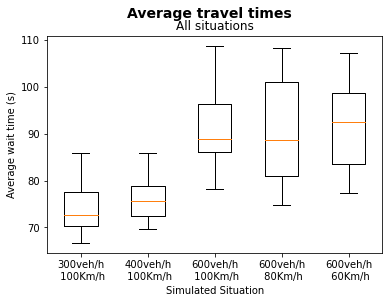

In [469]:
fig = plt.figure()
fig.suptitle('Average travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_travel_t, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

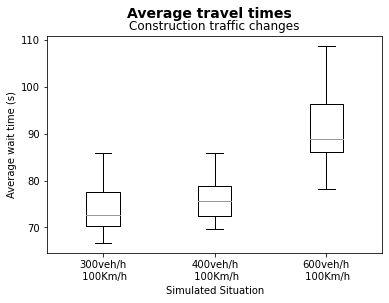

In [470]:
fig = plt.figure()
fig.suptitle('Average travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_travel_t[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

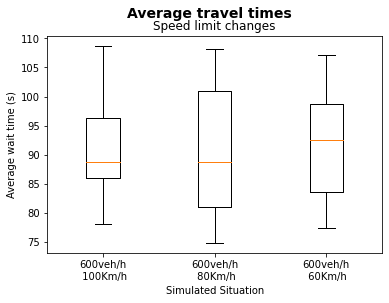

In [471]:
fig = plt.figure()
fig.suptitle('Average travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_travel_t[2:5], labels = bp_labels3)
ax.set_title('Speed limit changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

In [472]:
max_travel_t = maxTravelTime(RECS)
print("max travel times per simulation: ")
for i in range(len(max_travel_t)):
    print(labels[i], np.average(max_travel_t[i]))

max travel times per simulation: 
300veh/h  VMAXmain=100Km/h 103.724
400veh/h  VMAXmain=100Km/h 110.00550000000001
600veh/h  VMAXmain=100Km/h 160.98700000000002
600veh/h  VMAXmain=80Km/h 152.302
600veh/h  VMAXmain=60Km/h 156.919


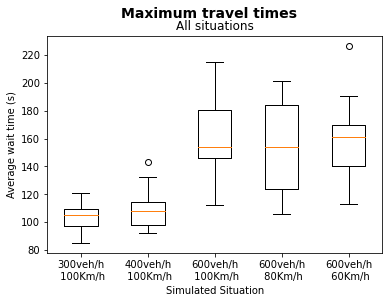

In [473]:
fig = plt.figure()
fig.suptitle('Maximum travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_travel_t, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

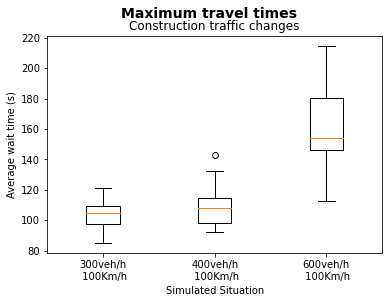

In [474]:
fig = plt.figure()
fig.suptitle('Maximum travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_travel_t[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

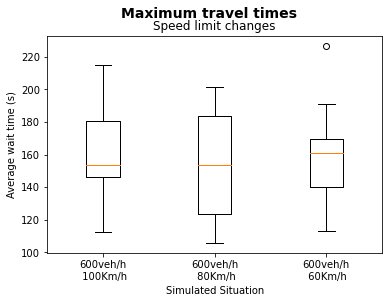

In [475]:
fig = plt.figure()
fig.suptitle('Maximum travel times', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_travel_t[2:5], labels = bp_labels3)
ax.set_title('Speed limit changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

In [476]:
avg_Q = avgQueueLength(RECS)
print("average queue length per simulation: ")
for i in range(len(avg_Q)):
    print(labels[i], np.average(avg_Q[i]))

average queue length per simulation: 
300veh/h  VMAXmain=100Km/h 2.0220000000000002
400veh/h  VMAXmain=100Km/h 2.117
600veh/h  VMAXmain=100Km/h 2.4585
600veh/h  VMAXmain=80Km/h 2.4425
600veh/h  VMAXmain=60Km/h 2.4875


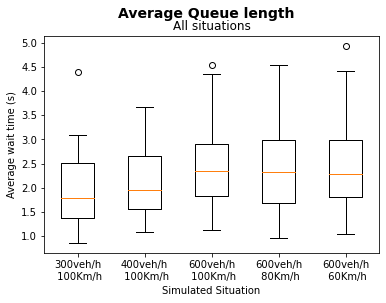

In [477]:
fig = plt.figure()
fig.suptitle('Average Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_Q, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

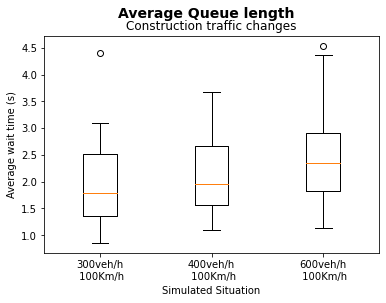

In [478]:
fig = plt.figure()
fig.suptitle('Average Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_Q[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

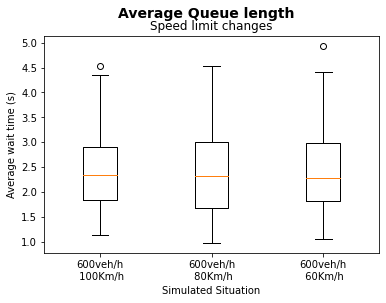

In [479]:
fig = plt.figure()
fig.suptitle('Average Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_Q[2:5], labels = bp_labels3)
ax.set_title('Speed limit changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

In [480]:
max_Q = maxQueueLength(RECS, roads = "Cross Rd", directions = "EAST")
print("maximum queue length per simulation: ")
for i in range(len(max_Q)):
    print(labels[i], np.average(max_Q[i]))

maximum queue length per simulation: 
300veh/h  VMAXmain=100Km/h 7.05
400veh/h  VMAXmain=100Km/h 7.35
600veh/h  VMAXmain=100Km/h 7.75
600veh/h  VMAXmain=80Km/h 7.75
600veh/h  VMAXmain=60Km/h 7.7


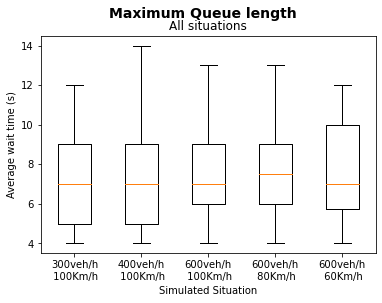

In [481]:
fig = plt.figure()
fig.suptitle('Maximum Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_Q, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

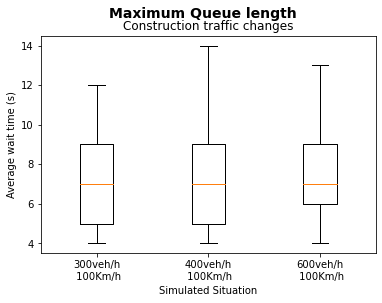

In [482]:
fig = plt.figure()
fig.suptitle('Maximum Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_Q[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

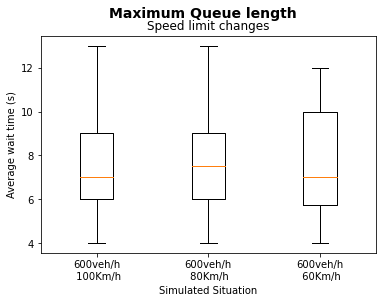

In [468]:
fig = plt.figure()
fig.suptitle('Maximum Queue length', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_Q[2:5], labels = bp_labels3)
ax.set_title('Speed limit changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

In [374]:
avg_wait_t = avgWaitTime(RECS)
print("average wait times per simulation: ")
for i in range(len(avg_wait_t)):
    print(labels[i], np.average(avg_wait_t[i]))

average wait times per simulation: 
300veh/h  VMAXmain=100Km/h 20.068
400veh/h  VMAXmain=100Km/h 22.256500000000003
600veh/h  VMAXmain=100Km/h 38.004000000000005
600veh/h  VMAXmain=80Km/h 37.532500000000006
600veh/h  VMAXmain=60Km/h 38.532


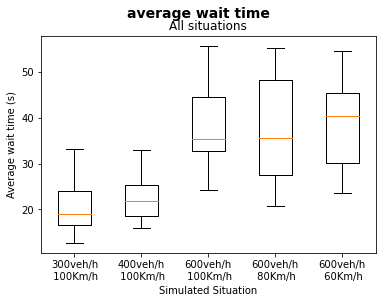

In [462]:
fig = plt.figure()
fig.suptitle('average wait time  ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_wait_t, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

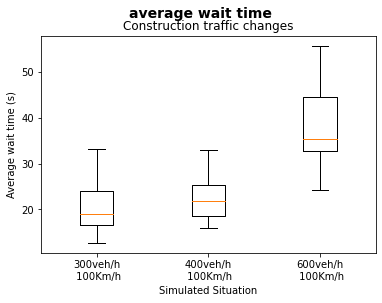

In [467]:
fig = plt.figure()
fig.suptitle('average wait time ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_wait_t[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

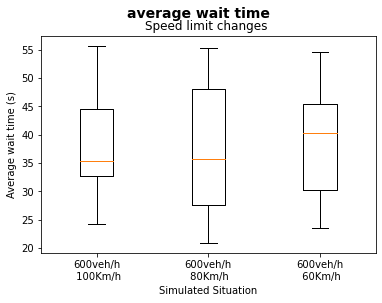

In [463]:
fig = plt.figure()
fig.suptitle('average wait time  ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(avg_wait_t[2:5], labels = bp_labels3)
ax.set_title('Speed limit changes ')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Average wait time (s)')

plt.show()

In [378]:
max_wait_t = maxWaitTime(RECS)
print("max wait times per simulation: ")
for i in range(len(max_wait_t)):
    print(labels[i], np.average(max_wait_t[i]))

max wait times per simulation: 
300veh/h  VMAXmain=100Km/h 51.315
400veh/h  VMAXmain=100Km/h 57.592999999999996
600veh/h  VMAXmain=100Km/h 108.42949999999999
600veh/h  VMAXmain=80Km/h 99.636
600veh/h  VMAXmain=60Km/h 104.29799999999997


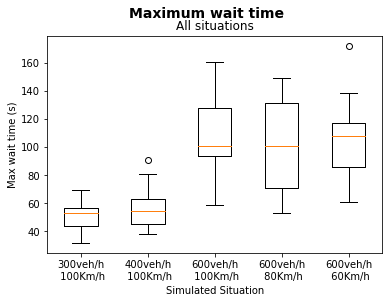

In [464]:
fig = plt.figure()
fig.suptitle('Maximum wait time ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_wait_t, labels = bp_labels)
ax.set_title('All situations')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Max wait time (s)')

plt.show()

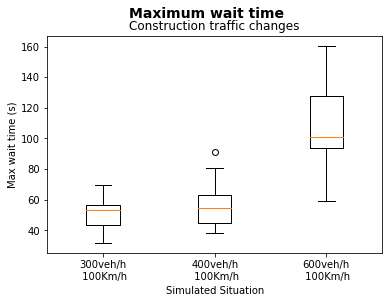

In [465]:
fig = plt.figure()
fig.suptitle('Maximum wait time ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_wait_t[0:3], labels = bp_labels1)
ax.set_title('Construction traffic changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Max wait time (s)')

plt.show()

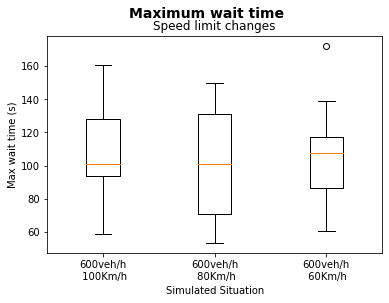

In [508]:
fig = plt.figure()
fig.suptitle('Maximum wait time ', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(max_wait_t[2:5], labels = bp_labels3 )
ax.set_title('Speed limit changes')
ax.set_xlabel('Simulated Situation')
ax.set_ylabel('Max wait time (s)')

plt.show()

In [ ]:
# table all variables 

In [487]:
np.average(max_wait_t[0])


51.315

In [489]:
d = {'variables':["avg travel time","max travel time", "avg Queue length", 
                  "Max Queue length", "avg wait times", "Max wait times"],
     '300veh/h @100km/h':[np.average(avg_travel_t[0]),
                          np.average(max_travel_t[0]),
                          np.average(avg_Q[0]),
                          np.average(max_Q[0]),
                          np.average(avg_wait_t[0]),
                          np.average(max_wait_t[0])],
     '400veh/h @100km/h':[np.average(avg_travel_t[1]),
                          np.average(max_travel_t[1]),
                          np.average(avg_Q[1]),
                          np.average(max_Q[1]),
                          np.average(avg_wait_t[1]),
                          np.average(max_wait_t[1])],
     '600veh/h @100km/h':[np.average(avg_travel_t[2]),
                          np.average(max_travel_t[2]),
                          np.average(avg_Q[2]),
                          np.average(max_Q[2]),
                          np.average(avg_wait_t[2]),
                          np.average(max_wait_t[2])],
     '600veh/h @80km/h':[np.average(avg_travel_t[3]),
                          np.average(max_travel_t[3]),
                          np.average(avg_Q[3]),
                          np.average(max_Q[3]),
                          np.average(avg_wait_t[3]),
                          np.average(max_wait_t[3])] ,
     '600veh/h @60km/h':[np.average(avg_travel_t[4]),
                          np.average(max_travel_t[4]),
                          np.average(avg_Q[4]),
                          np.average(max_Q[4]),
                          np.average(avg_wait_t[4]),
                          np.average(max_wait_t[4])]}
df = pd.DataFrame(data=d)
df

,variables,300veh/h @100km/h,400veh/h @100km/h,600veh/h @100km/h,600veh/h @80km/h,600veh/h @60km/h
0,avg travel time,73.7215,75.8685,91.3035,90.8545,91.8190
1,max travel time,103.7240,110.0055,160.9870,152.3020,156.9190
2,avg Queue length,2.0220,2.1170,2.4585,2.4425,2.4875
3,Max Queue length,7.0500,7.3500,7.7500,7.7500,7.7000
4,avg wait times,20.0680,22.2565,38.0040,37.5325,38.5320
5,Max wait times,51.3150,57.5930,108.4295,99.6360,104.2980


In [507]:
d = {'variables':["avg travel time","max travel time", "avg Queue length", 
                  "Max Queue length", "avg wait times", "Max wait times"],
     '300veh/h @100km/h to 400veh/h @100km/h':[t_test(avg_travel_t[0], avg_travel_t[1]),
                          t_test(max_travel_t[0], max_travel_t[1]),
                          t_test(avg_Q[0], avg_Q[1]),
                          t_test(max_Q[0], max_Q[1]),
                          t_test(avg_wait_t[0], avg_wait_t[1]),
                          t_test(max_wait_t[0], max_wait_t[1])],
     '300veh/h @100km/h to 600veh/h @100km/h':[t_test(avg_travel_t[0], avg_travel_t[2]),
                          t_test(max_travel_t[0], max_travel_t[2]),
                          t_test(avg_Q[0], avg_Q[2]),
                          t_test(max_Q[0], max_Q[2]),
                          t_test(avg_wait_t[0], avg_wait_t[2]),
                          t_test(max_wait_t[0], max_wait_t[2])],
     '600veh/h @100km/h to 600veh/h @80km/h':[t_test(avg_travel_t[2], avg_travel_t[3]),
                          t_test(max_travel_t[2], max_travel_t[3]),
                          t_test(avg_Q[2], avg_Q[3]),
                          t_test(max_Q[2], max_Q[3]),
                          t_test(avg_wait_t[2], avg_wait_t[3]),
                          t_test(max_wait_t[2], max_wait_t[3])],
     '600veh/h @100km/h to 600veh/h @80km/h':[t_test(avg_travel_t[2], avg_travel_t[4]),
                          t_test(max_travel_t[2], max_travel_t[4]),
                          t_test(avg_Q[2], avg_Q[4]),
                          t_test(max_Q[2], max_Q[4]),
                          t_test(avg_wait_t[2], avg_wait_t[4]),
                          t_test(max_wait_t[2], max_wait_t[4])] 
}



df = pd.DataFrame(data=d)
df

,variables,300veh/h @100km/h to 400veh/h @100km/h,300veh/h @100km/h to 600veh/h @100km/h,600veh/h @100km/h \n to 600veh/h @80km/h,600veh/h @100km/h to 600veh/h @80km/h
0,avg travel time,0.161280,1.600000e-08,0.887176,0.858212
1,max travel time,0.110092,2.000000e-09,0.348526,0.635257
2,avg Queue length,0.721962,1.486244e-01,0.960665,0.927251
3,Max Queue length,0.704068,3.641503e-01,1.000000,0.948641
4,avg wait times,0.170602,1.700000e-08,0.884140,0.857494
5,Max wait times,0.127323,2.000000e-09,0.343568,0.630440
